In [200]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.dates as mdates
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout,GRU
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from tensorflow.keras import optimizers, Model
import matplotlib.pyplot as plt
import math

# Load Data

In [201]:
import os
CURR_FOLDER_PATH = os.getcwd()
BASE_PATH = os.path.dirname(os.path.dirname(CURR_FOLDER_PATH))
DATA_PATH = os.path.join(BASE_PATH, 'Lulus/data')

In [202]:
df = pd.read_excel(DATA_PATH + '/datalagrev.xlsx')
# Data yang digunakan yaitu Harga cabai Rawit dan Harga Bawang putih sebagai Barang Subtitusi Sudah dilakukan lag - 1 Minggu

In [203]:
df

,Tanggal,Harga Bawang Putih,Harga Cabai Merah,Harga Cabai Rawit
0,01/ 01/ 2018,17050.0,31500.0,22150.0
1,08/ 01/ 2018,17300.0,32450.0,28550.0
2,15/ 01/ 2018,18050.0,34000.0,33650.0
3,22/ 01/ 2018,18550.0,31700.0,33800.0
4,29/ 01/ 2018,18050.0,29550.0,35950.0
...,...,...,...,...
309,04/ 12/ 2023,32850.0,75150.0,68950.0
310,11/ 12/ 2023,32750.0,85500.0,68800.0
311,18/ 12/ 2023,32750.0,80200.0,67550.0
312,25/ 12/ 2023,33400.0,62050.0,61200.0


# Statistical Analytics

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tanggal             314 non-null    object 
 1   Harga Bawang Putih  313 non-null    float64
 2   Harga Cabai Merah   313 non-null    float64
 3   Harga Cabai Rawit   313 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.9+ KB


In [205]:
df.shape

(314, 4)

In [206]:
df['Harga Cabai Merah'] = df['Harga Cabai Merah'].astype('float64')
df['Harga Bawang Putih'] = df['Harga Bawang Putih'].astype('float64')
df['Harga Cabai Rawit'] = df['Harga Cabai Rawit'].astype('float64')

In [207]:
import seaborn as sns
# Statistik Deskriptif Harga
harga_stats = df['Harga Cabai Merah'].describe()
print("\nStatistik Deskriptif Harga:")
print(harga_stats)


Statistik Deskriptif Harga:
count      313.000000
mean     34189.297125
std      14091.005342
min      15300.000000
25%      24200.000000
50%      31750.000000
75%      39200.000000
max      95250.000000
Name: Harga Cabai Merah, dtype: float64


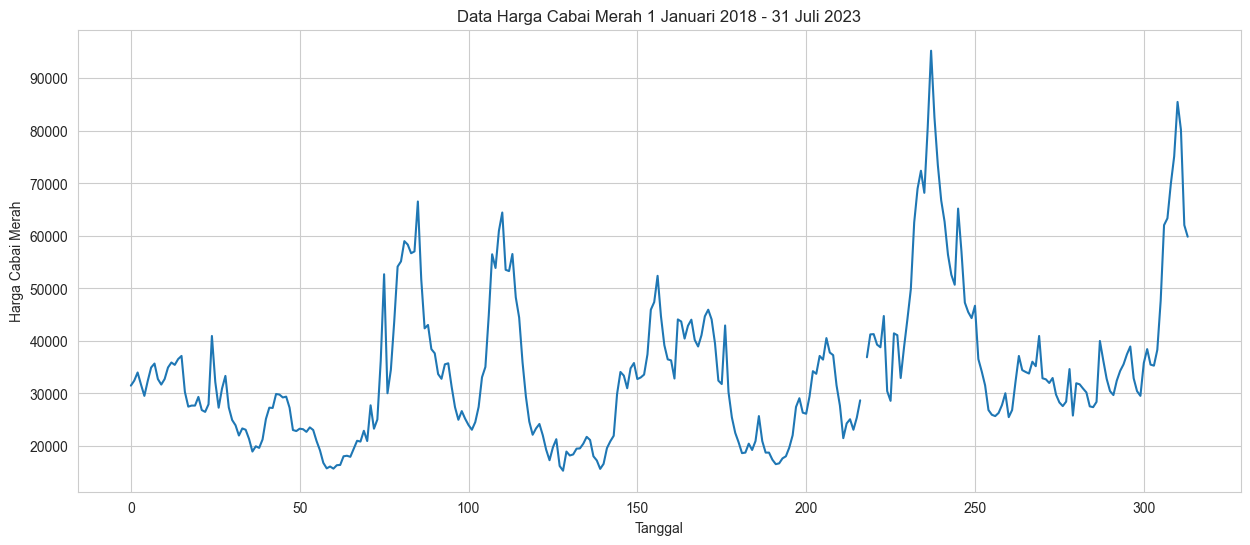

In [208]:
# Visualisasi
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Harga Cabai Merah'])
plt.title('Data Harga Cabai Merah 1 Januari 2018 - 31 Juli 2023')
plt.xlabel('Tanggal')
plt.ylabel('Harga Cabai Merah')
plt.show()

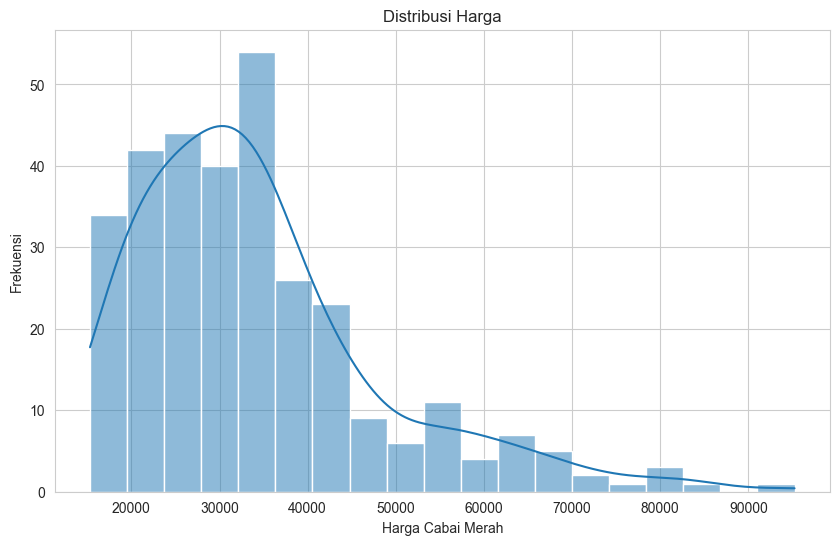

In [209]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Harga Cabai Merah'], kde=True)
plt.title('Distribusi Harga')
plt.xlabel('Harga Cabai Merah')
plt.ylabel('Frekuensi')
plt.show()

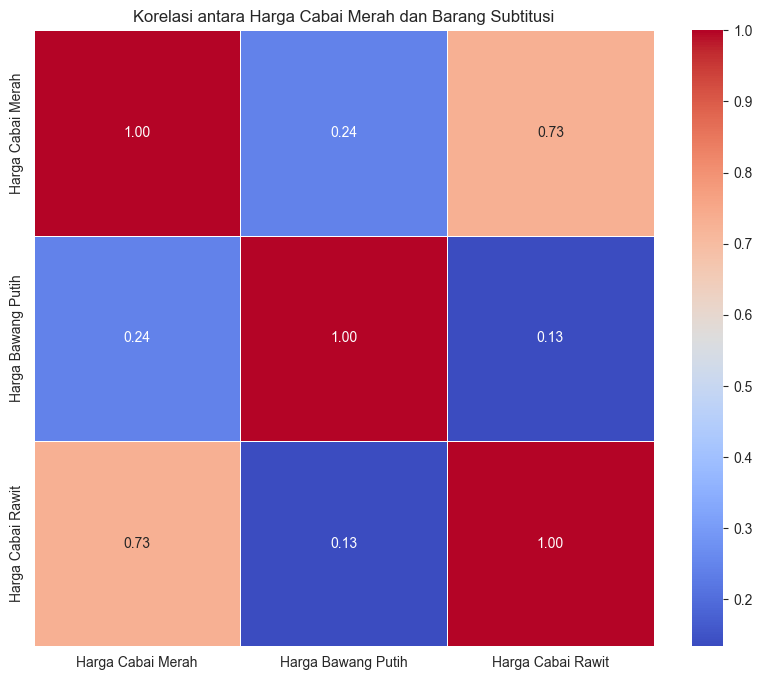

In [210]:
corr_with_target = df[['Harga Cabai Merah','Harga Bawang Putih','Harga Cabai Rawit']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Korelasi antara Harga Cabai Merah dan Barang Subtitusi')
plt.show()

# Preprocessing Data


In [211]:
df.isnull().sum()

Tanggal               0
Harga Bawang Putih    1
Harga Cabai Merah     1
Harga Cabai Rawit     1
dtype: int64

In [212]:
df = df.fillna(df.mean())

C:\Users\ihsan\AppData\Local\Temp\ipykernel_20356\114435927.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


In [213]:
scaler_rr = MinMaxScaler(feature_range=(0, 1))
scaler_harga = MinMaxScaler(feature_range=(0, 1))
df['Harga Cabai Merah_Scaled'] = scaler_harga.fit_transform(df[['Harga Cabai Merah']])
df['Harga Bawang Putih_Scaled'] = scaler_rr.fit_transform(df[['Harga Bawang Putih']])
df['Harga Cabai Rawit_Scaled'] = scaler_rr.fit_transform(df[['Harga Cabai Rawit']])

# Split Data

In [214]:
selected_columns = ['Harga Cabai Merah_Scaled','Harga Bawang Putih_Scaled','Harga Cabai Rawit_Scaled']
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)][selected_columns].values
        dataX.append(a)
        dataY.append(dataset[i + look_back:i + look_back + 1]['Harga Cabai Merah_Scaled'].values)
    return np.array(dataX), np.array(dataY)

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], len(selected_columns)))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], len(selected_columns)))

# Pembuatan Model

In [215]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 3), activation='relu'))
model.add(LSTM(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(trainX, trainY, epochs=60, batch_size=64, verbose=2)


Epoch 1/60
4/4 - 1s - loss: 0.0812 - 1s/epoch - 316ms/step
Epoch 2/60
4/4 - 0s - loss: 0.0765 - 9ms/epoch - 2ms/step
Epoch 3/60
4/4 - 0s - loss: 0.0716 - 8ms/epoch - 2ms/step
Epoch 4/60
4/4 - 0s - loss: 0.0671 - 9ms/epoch - 2ms/step
Epoch 5/60
4/4 - 0s - loss: 0.0620 - 8ms/epoch - 2ms/step
Epoch 6/60
4/4 - 0s - loss: 0.0562 - 8ms/epoch - 2ms/step
Epoch 7/60
4/4 - 0s - loss: 0.0513 - 9ms/epoch - 2ms/step
Epoch 8/60
4/4 - 0s - loss: 0.0464 - 9ms/epoch - 2ms/step
Epoch 9/60
4/4 - 0s - loss: 0.0408 - 8ms/epoch - 2ms/step
Epoch 10/60
4/4 - 0s - loss: 0.0358 - 9ms/epoch - 2ms/step
Epoch 11/60
4/4 - 0s - loss: 0.0311 - 8ms/epoch - 2ms/step
Epoch 12/60
4/4 - 0s - loss: 0.0275 - 8ms/epoch - 2ms/step
Epoch 13/60
4/4 - 0s - loss: 0.0245 - 8ms/epoch - 2ms/step
Epoch 14/60
4/4 - 0s - loss: 0.0221 - 9ms/epoch - 2ms/step
Epoch 15/60
4/4 - 0s - loss: 0.0212 - 8ms/epoch - 2ms/step
Epoch 16/60
4/4 - 0s - loss: 0.0206 - 8ms/epoch - 2ms/step
Epoch 17/60
4/4 - 0s - loss: 0.0206 - 8ms/epoch - 2ms/step
Epoch

In [216]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 1, 50)             10800     
                                                                 
 lstm_17 (LSTM)              (None, 64)                29440     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 40,305
Trainable params: 40,305
Non-trainable params: 0
_________________________________________________________________


In [217]:
predictions = model.predict(testX)
predictions = scaler_harga.inverse_transform(predictions)
testY = scaler_harga.inverse_transform(testY)

2/2 [==============================] - 0s 2ms/step


In [218]:
trainY = scaler_harga.inverse_transform(trainY)

In [219]:
df_test = pd.DataFrame({'Actual': np.squeeze(testY), 'Predicted': np.squeeze(predictions)})
df_test.head(15)

,Actual,Predicted
0,34200.0,34525.480469
1,31550.0,32360.433594
2,26850.0,30210.968750
3,25950.0,26830.351562
4,25700.0,26178.312500
5,26300.0,25984.662109
6,27800.0,26482.427734
7,30050.0,27652.445312
8,25500.0,29815.902344
9,26850.0,26576.824219


# Hasil Akhir

In [222]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df.set_index('Tanggal', inplace=True)

In [226]:
df.sort_index(inplace=True)
df.index = pd.to_datetime(df.index)

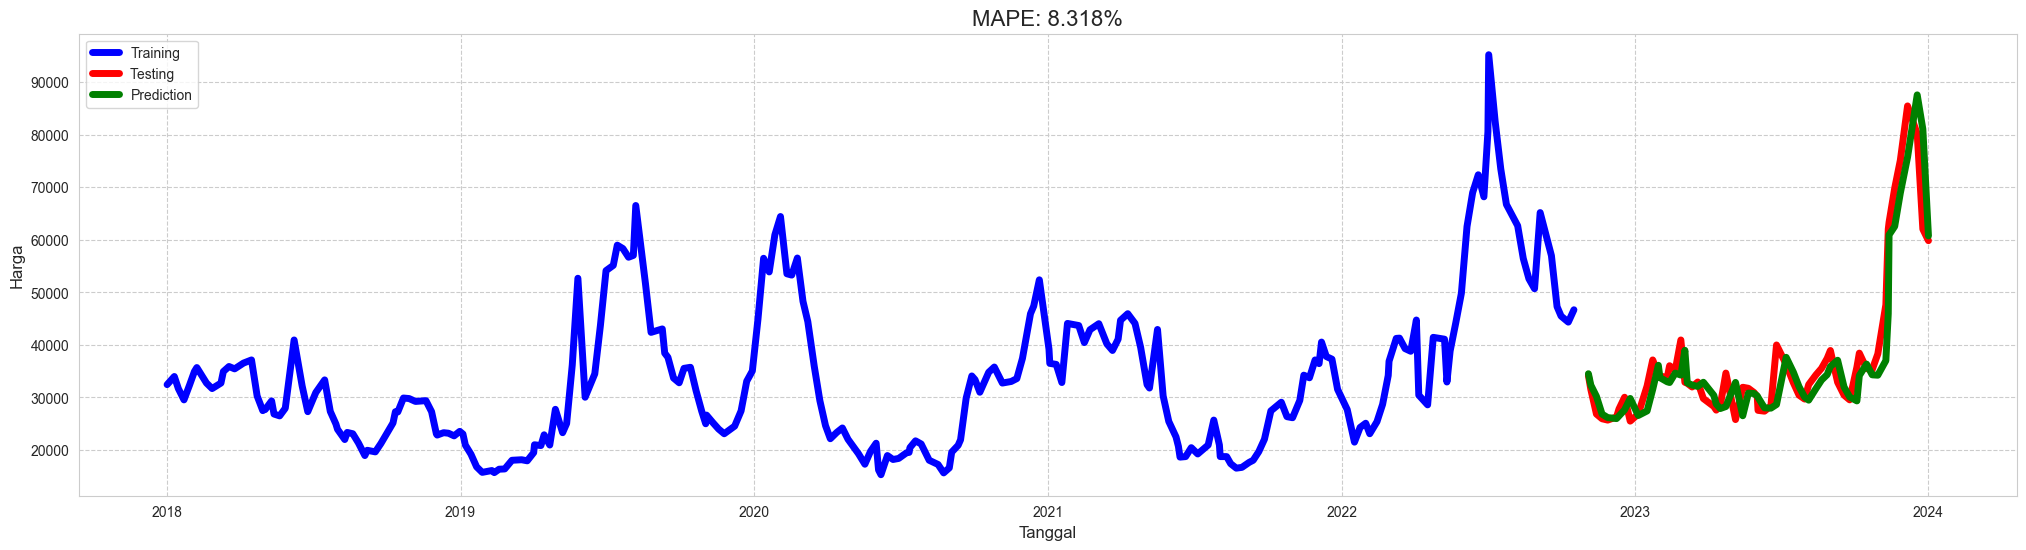

In [227]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(testY, predictions)*100
plt.figure(figsize=(25, 6))
plt.plot(df.index[:len(trainY)], trainY, label='Training', marker='', color='blue', linestyle='-', linewidth=5)
plt.plot(df.index[-len(testY):], testY, label='Testing ', marker='', color='red', linestyle='-', linewidth=5)
plt.plot(df.index[-len(predictions):], predictions, label='Prediction', marker='', color='green', linestyle='-', linewidth=5)
plt.title(f'MAPE: {mape:.3f}%', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
plt.xticks(rotation=0)
plt.show()

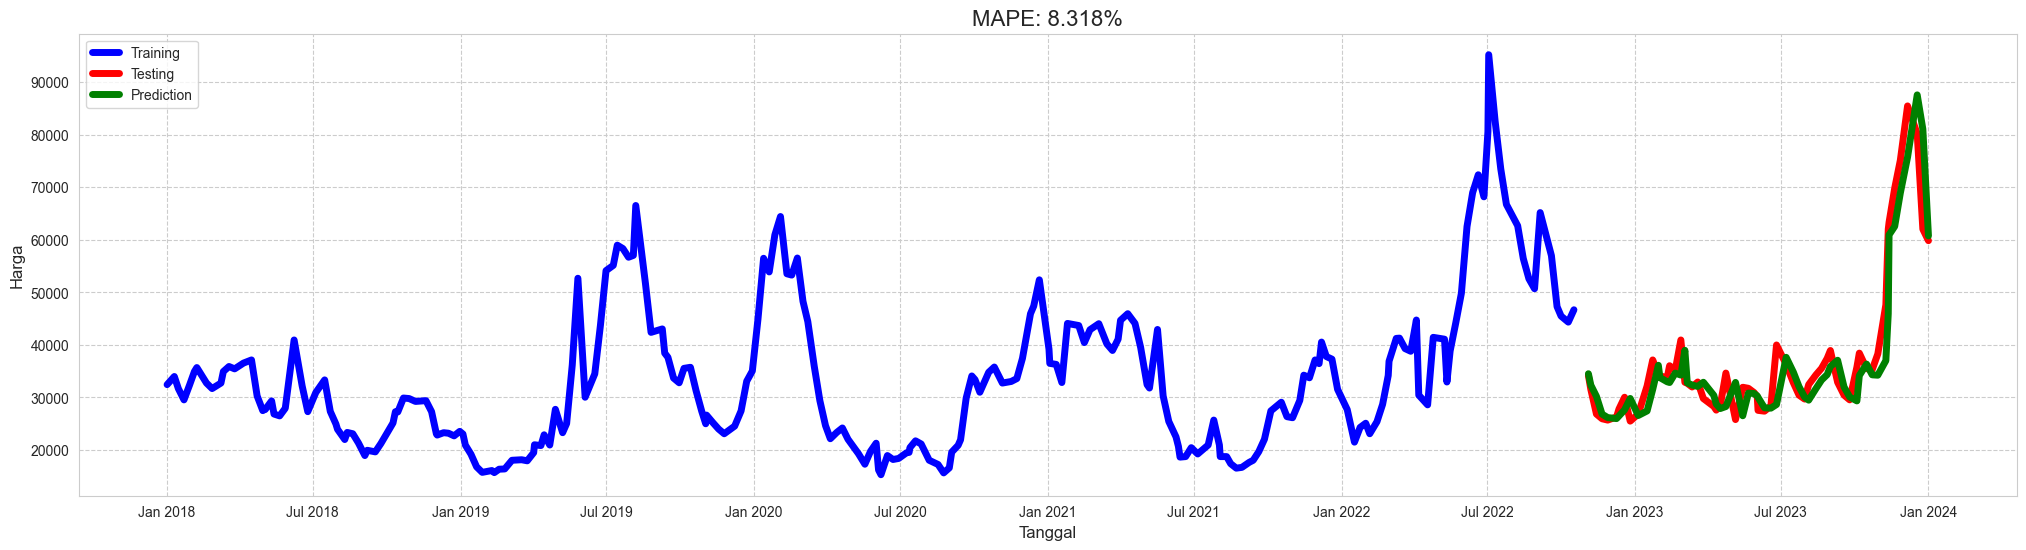

In [250]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib.dates import MonthLocator, DateFormatter
mape = mean_absolute_percentage_error(testY, predictions)*100
plt.figure(figsize=(25, 6))
plt.plot(df.index[:len(trainY)], trainY, label='Training', marker='', color='blue', linestyle='-', linewidth=5)
plt.plot(df.index[-len(testY):], testY, label='Testing', marker='', color='red', linestyle='-', linewidth=5)
plt.plot(df.index[-len(predictions):], predictions, label='Prediction', marker='', color='green', linestyle='-', linewidth=5)
plt.title(f'MAPE: {mape:.3f}%', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.grid(True, linestyle='--', alpha=1)
plt.legend()
locator = MonthLocator(bymonth=[1, 7])
formatter = DateFormatter('%b %Y')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks(rotation=0)
plt.show()
